- 상관계수까지만 컬럼제거(VIF ❌)
- 임계치 변경
- RandomForest 훈련
- RFE

In [ ]:
# colab에서 실행시 matplotlib에 한글을 표시하기 위해서 본 셀을 실행후 runtime을 재시작해야 함
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Display_Sensor_Anomaly_Analysis"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
 
## colab용 글씨체 설정
plt.rc('font', family='NanumBarunGothic') 

## local jupyter 용 글씨체 설정
# font_path = "C:\Windows\Fonts\malgun.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# mpl.rc('font', family=font)

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 레이블 데이터 불러오기

In [ ]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/data/'
fact_lr_labels = pd.read_csv(working_dir + 'fact_lr_labels.csv', index_col=0)
y_data = fact_lr_labels.iloc[:, 0:1]
print(y_data.shape)
print(y_data)

(8145, 1)
                   L.RD
dat...date.name.       
2016-01-01 07     0.025
2016-01-01 08     0.000
2016-01-01 09     0.016
2016-01-01 10     0.000
2016-01-01 11     0.000
...                 ...
2016-12-31 19     0.000
2016-12-31 20     0.010
2016-12-31 21     0.017
2016-12-31 22     0.000
2016-12-31 23     0.000

[8145 rows x 1 columns]


## 3.함수 생성

### 1) 데이터 스케일링결과를 반환하는 함수

In [ ]:
def scale(feature_data):
    from sklearn.preprocessing import MinMaxScaler
    minMaxScaler = MinMaxScaler()
    %time print(minMaxScaler.fit(feature_data))
    feature_data_minMaxScaled =  pd.DataFrame(minMaxScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    # from sklearn.preprocessing import MaxAbsScaler
    # maxAbsScaler = MaxAbsScaler()
    # %time print(maxAbsScaler.fit(feature_data))
    # feature_data_maxAbsScaled = pd.DataFrame(maxAbsScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import StandardScaler
    standardScaler = StandardScaler()
    %time print(standardScaler.fit(feature_data))
    feature_data_standardScaled = pd.DataFrame(standardScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)

    from sklearn.preprocessing import RobustScaler
    robustScaler = RobustScaler()
    %time print(robustScaler.fit(feature_data))
    feature_data_robustScaled = pd.DataFrame(robustScaler.transform(feature_data), columns=feature_data.columns, index=feature_data.index)
    return feature_data_minMaxScaled, feature_data_standardScaled, feature_data_robustScaled

### 2) pca주성분 결과의 누적 기여율이 90%가 되는 피처개수를 구하는 함수

In [ ]:
def get_pca(feature_data, n_components=2):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_components)
    pca.fit(feature_data)
    feature_data_pca = pca.transform(feature_data)
    if n_components==2 :
        feature_data_pca =  pd.DataFrame(data=feature_data_pca, columns=['PC1','PC2'], index=feature_data.index)
        print(feature_data_pca)
        sns.scatterplot(x=feature_data_pca.iloc[:,0], y=feature_data_pca.iloc[:,1])
    else :
        draw_elbowpoint(pca)
        # 주성분의 설명력과 기여율 구하기
        result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
                    '기여율':pca.explained_variance_ratio_},
                    index=np.array([f"pca{num+1}" for num in range(feature_data_pca.shape[1])]))
        result['누적기여율'] = result['기여율'].cumsum()
        print_cumsum90(result)
        print('<전체 누적기여율>\n', result)

In [ ]:
def print_cumsum90(result):
    result_mask = result['누적기여율'] <= 0.9
    print('누적기여율이 90%가 되는 피처의 수 : ', len(result[result_mask]))
    print(result[result_mask].tail(5))

### 3) Elbow Point그리는 함수

In [ ]:
def draw_elbowpoint(pca):
    plt.figure(figsize=(16, 6))
    plt.plot(pca.explained_variance_ratio_, marker='o', c='blue')
    plt.xlabel("n_components", fontsize=20)
    plt.ylabel("explained_variance_ratio_", fontsize=20)

# 🎈VIF계수를 이용하여 컬럼제거 안한 데이터

## 1.피처와 레이블데이터 불러오기
- 피처의 크기 : 8145 rows × 324 columns(dat...date.name.는 index임)
- 레이블의 크기 : 8145 rows × 4 columns

In [ ]:
working_dir = '/content/drive/MyDrive/Colab Notebooks/k-digital/[Project]Display_Sensor_Anomaly_Analysis/data/'
fact_lr_noVIF_feature = pd.read_csv(working_dir + 'fact_lr_noVIF_feature.csv', index_col=0)

print(fact_lr_noVIF_feature.shape)

(8145, 324)


## 2.데이터스케일링

### 1) 데이터스케일링 하기전 피처의 통계정보확인

In [ ]:
fact_lr_noVIF_feature.describe()

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,X1WOS45101_PV,X1WOS45105_PV,X1WOS45106_PV,X1WOS45107_PV,X1WOS45109_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DCS_Offset_RPM_M16.1WOS45116_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DAMP.POSITION.1.BAY.CTRL.1TIC33421.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ROOF.HEATING.Zone.7.1JIC31107.PV,ROOF.HEATING.Zone.8.1JIC31108.PV,ROOF.HEATING.Zone.9.1JIC31109.PV,ATM.FLOW.SECT.8.N2.H2.1FI33414.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,cluster,Gross.width,Left.edge,UPPER.AB1.Z1.TMP.1TIC41101.PV,UPPER.AB1.Z6.TMP.1TIC41106.PV,LOWER.AB1.Z9.TMP.1TIC41152.PV,UPPER.AB2.Z20.TMP.1TIC41206.PV,LOWER.AB3.Z37.TMP.1TIC41352.PV,UPPER.AB5.Z57.TMP.1TIC41501.PV,LOWER.AB5.Z67.TMP.1TIC41554.PV,LOWER.AB5.Z69.TMP.1TIC41556.PV,UPPER.AB6.Z71.TMP.1TIC41601.PV,LOWER.AB6.Z78.TMP.1TIC41651.PV,LOWER.AB6.Z83.TMP.1TIC41656.PV,LOWER.AB7.Z92.TMP.1TIC41751.PV,UPPER.AB8.Z99.TMP.1TIC41801.PV,UPPER.AB8.Z101TMP.1TIC41803.PV,UPPER.AB8.Z102.TMP.1TIC41804.PV,...,D_C1_L_UL,D_C2_L_UL,D_C3_L_UL,D_GLS_AB1_LR,D_GLS_AB11_LR,D_GLS_AB7_LR,D_GLS_C4_LR,D_GLS_F_LR,D_GLS_RET_LR,S_AB1_AB2_U_L,S_AB1_AB2_L_L,S_AB2_AB3_U_L,S_AB2_AB3_L_L,S_AB3_AB4_U_L,S_AB4_AB5_U_L,S_AB5_AB6_U_L,S_AB6_AB7_U_L,S_AB6_AB7_L_L,S_AB7_AB8_U_L,S_AB7_AB8_L_L,S_AB8_AB9_U_L,S_AB8_AB9_L_L,S_AB9_AB10_U_L,S_AB9_AB10_L_L,S_AB10_AB11_U_L,S_AB10_AB11_L_L,S_AB11_C1_U_L,S_AB11_C1_L_L,S_C1_C2_U_L,S_C1_C2_L_L,S_C2_C3_U_L,S_C2_C3_L_L,S_C3_C4_U_L,S_AB1_AB11_L,S_AB11_AB7_L,S_AB7_C4_L,S_C4_RET_L,S_RET_F_L,STD_U_L,STD_GLS_L
count,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,...,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000,8145.000000
mean,0.000728,-0.000184,-0.000456,-0.000109,-0.000066,-0.000066,-0.000126,0.000195,-0.000258,0.000865,0.000080,-0.000921,-0.001064,-0.000745,-0.001166,0.000506,-0.000164,-0.000515,-0.000324,-0.000607,-0.001575,-0.002465,-0.001554,0.000362,0.000672,-0.000376,-0.000477,-0.000248,-0.000077,0.000236,-0.000101,0.000139,0.000291,0.000133,0.000194,0.000253,0.000096,-0.000270,0.000408,0.000631,...,0.000244,-0.000795,-0.000938,0.000963,0.000196,0.001651,-0.000188,0.000196,0.001021,-0.000788,-0.000770,-0.000435,-0.000014,0.000010,0.000490,-0.000193,-0.000032,0.000043,0.000028,0.000036,0.000203,0.000335,0.000325,0.000005,-0.000254,-0.000536,-0.000230,0.000028,0.000592,-0.000530,-0.000501,-0.000437,0.000242,-0.000673,0.000358,0.000159,-0.001295,0.000231,0.000351,-0.000434
std,1.000121,1.000407,1.000309,1.000423,1.000427,1.000427,1.000420,1.000407,1.000391,0.999994,1.000426,0.999936,0.999770,1.000106,0.999638,1.000281,1.000414,1.000275,1.000369,1.000215,0.998984,0.996887,0.999022,1.000346,1.000141,1.000347,1.000297,1.000394,1.000426,1.000397,1.000423,1.000417,1.000380,1.000417,1.000407,1.000392,1.000423,1.000387,1.000332,1.000197,...,1.000327,0.999924,0.999803,0.999890,1.000403,0.998840,1.000407,1.000402,0.999817,1.000066,1.000084,1.000319,1.000429,1.000429,1.000289,1.000407,1.000429,1.000428,1.000428,1.000427,1.000405,1.000364,1.000367,1.000430,1.000392,1.000257,1.000399,1

### 2) 데이터 스케일링결과 취득

In [ ]:
X_mm_noVIF_scaled, X_std_noVIF_scaled, X_rbs_noVIF_scaled =  scale(fact_lr_noVIF_feature)

MinMaxScaler(copy=True, feature_range=(0, 1))
CPU times: user 9.67 ms, sys: 105 µs, total: 9.78 ms
Wall time: 9.78 ms
StandardScaler(copy=True, with_mean=True, with_std=True)
CPU times: user 37 ms, sys: 4 ms, total: 41 ms
Wall time: 41.1 ms
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)
CPU times: user 107 ms, sys: 37 µs, total: 107 ms
Wall time: 107 ms


## 3.주성분분석

### 1) 스케일링 안한 데이터

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  49
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca45          1.002432  0.003094  0.887606
pca46          1.001101  0.003090  0.890696
pca47          0.997168  0.003078  0.893773
pca48          0.996670  0.003076  0.896850
pca49          0.980524  0.003026  0.899876
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        6.556426e+01  2.023615e-01  0.202361
pca2        3.626428e+01  1.119283e-01  0.314290
pca3        2.357826e+01  7.277336e-02  0.387063
pca4        1.738115e+01  5.364622e-02  0.440709
pca5        1.603091e+01  4.947878e-02  0.490188
...                  ...           ...       ...
pca320      8.116243e-20  2.505047e-22  1.000000
pca321      8.044306e-20  2.482843e-22  1.000000
pca322      7.897378e-20  2.437495e-22  1.000000
pca323      7.751026e-20  2.392324e-22  1.000000
pca324      7.718161e-20  2.382180e-22  1.000000

[324 rows x 3 columns]


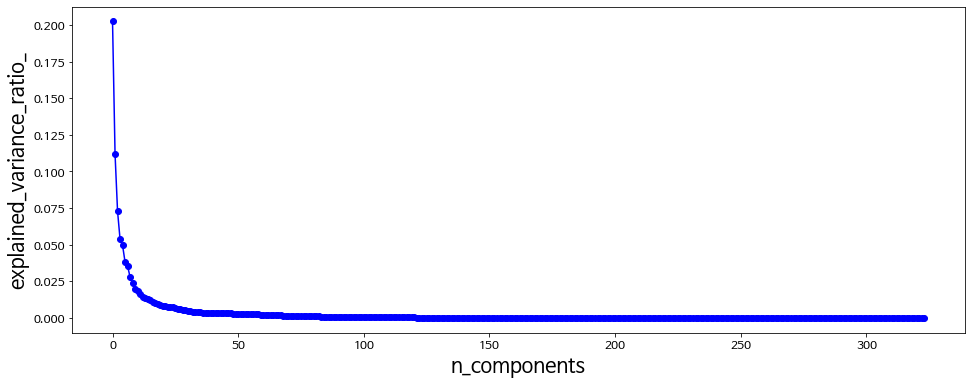

In [ ]:
get_pca(fact_lr_noVIF_feature, len(fact_lr_noVIF_feature.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                        PC1       PC2
dat...date.name.                     
2016-01-01 07     22.135676 -7.977360
2016-01-01 08     21.579658 -7.797956
2016-01-01 09     22.199069 -7.895591
2016-01-01 10     21.949192 -8.009232
2016-01-01 11     22.953605 -8.112407
...                     ...       ...
2016-12-31 19     -1.218127 -8.855158
2016-12-31 20     -1.001158 -9.207071
2016-12-31 21     -1.042699 -8.789397
2016-12-31 22     -0.800874 -8.879897
2016-12-31 23     -0.905449 -9.027726

[8145 rows x 2 columns]


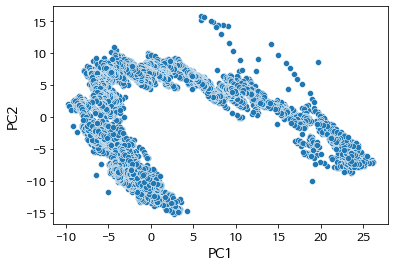

In [ ]:
get_pca(fact_lr_noVIF_feature)

### 2) MinMaxScaling

#### 누적기여율과 elbowPoint확인

누적기여율이 90%가 되는 피처의 수 :  23
       설명가능한 분산 비율(고윳값)       기여율     누적기여율
pca19          0.052316  0.007132  0.874234
pca20          0.045991  0.006270  0.880503
pca21          0.041998  0.005725  0.886228
pca22          0.040721  0.005551  0.891780
pca23          0.037308  0.005086  0.896865
<전체 누적기여율>
         설명가능한 분산 비율(고윳값)           기여율     누적기여율
pca1        2.361021e+00  3.218582e-01  0.321858
pca2        1.078207e+00  1.469829e-01  0.468841
pca3        7.324637e-01  9.985062e-02  0.568692
pca4        3.995449e-01  5.446659e-02  0.623158
pca5        3.081027e-01  4.200105e-02  0.665159
...                  ...           ...       ...
pca320      9.561049e-22  1.303377e-22  1.000000
pca321      7.409104e-22  1.010021e-22  1.000000
pca322      6.537417e-22  8.911910e-23  1.000000
pca323      4.665133e-22  6.359584e-23  1.000000
pca324      4.493219e-22  6.125228e-23  1.000000

[324 rows x 3 columns]


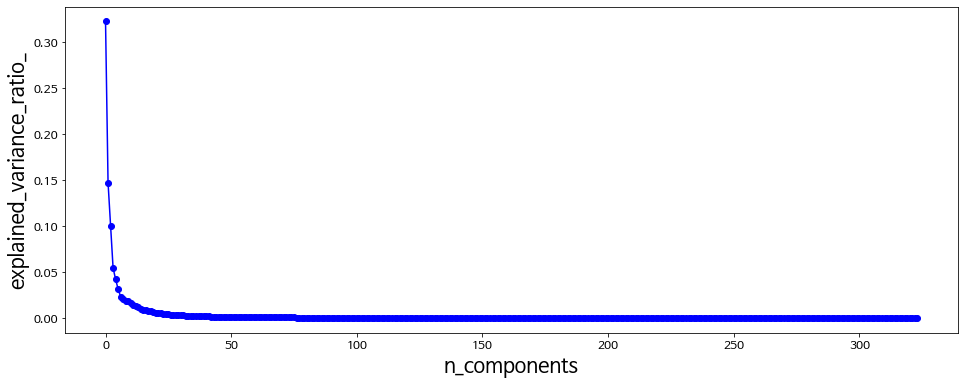

In [ ]:
get_pca(X_mm_noVIF_scaled, len(X_mm_noVIF_scaled.columns))

#### n_components 2개 설정시 PC1 과 PC2의 관계

                       PC1       PC2
dat...date.name.                    
2016-01-01 07     3.452587  1.529799
2016-01-01 08     3.437222  1.511311
2016-01-01 09     3.464805  1.526781
2016-01-01 10     3.467175  1.539693
2016-01-01 11     3.532527  1.550058
...                    ...       ...
2016-12-31 19    -0.409801  2.174725
2016-12-31 20    -0.391770  2.202924
2016-12-31 21    -0.373658  2.184747
2016-12-31 22    -0.358247  2.216913
2016-12-31 23    -0.364460  2.222958

[8145 rows x 2 columns]


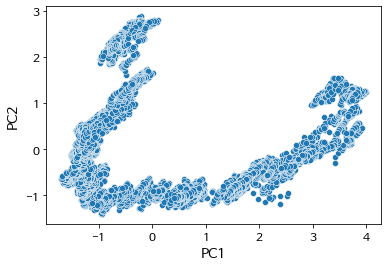

In [ ]:
get_pca(X_mm_noVIF_scaled)

# RandomForest 모델링

## 1.공통처리

### 1) 공통 모듈 임포트

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

### 2) 함수 생성

#### 1) show_labels_cnt : 양품과 불량품의 비율 그래프를 생성하는 함수

In [ ]:
def show_all_labels_cnt(y_df):
    rows = 2
    cols = 2
    # constrained_layout : 플롯간의 간격을 자동으로 조절
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(10,8))
    for i in range(len(y_df.columns)):
        # 양품의 개수
        good_RD = y_df.iloc[:,i].value_counts()[0]
        # 불량품의 개수
        bad_RD = y_df.iloc[:,i].value_counts()[1]
        # 카운트 그래프
        a = sns.countplot(x=y_df.columns[i], data=y_df, ax=ax[i//2, i%2])
        cnt = 0
        for p in a.patches:
            height = p.get_height() # 그래프의 높이(개수를 그래프위에 표시하기 위해 필요)
            # 개수를 그래프에 표시
            a.text(p.get_x()+p.get_width()/2., height + 0.1, y_df.iloc[:,i].value_counts()[cnt],ha="center")
            cnt += 1
    plt.show()

In [ ]:
def show_one_labels_cnt(new_label_df):
    for i in range(len(new_label_df.columns)):
        plt.figure(figsize=(8,6))
        good_RD = new_label_df.iloc[:,i].value_counts()[0]
        bad_RD = new_label_df.iloc[:,i].value_counts()[1]
        ax = sns.countplot(x=new_label_df.columns[i], data=new_label_df)
        ax.set_xticklabels(['양품', '불량품'])
        ax.set_xlabel('양품/불량품')
        ax.text(-0.1,good_RD + 5,good_RD, fontdict=dict(fontsize=20))
        ax.text(0.9,bad_RD + 5,bad_RD, fontdict=dict(fontsize=20))
        plt.title(f"{new_label_df.columns[i]}의 양품/ 불량품 갯수")
        plt.show()

#### 2) get_clf_eval : 분류에서의 평가지표를 출력해주는 함수

In [ ]:
## 분류에서의 평가지표를 출력해주는 함수
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)

    print('정확도:', accuracy)
    print('정밀도:', precision)
    print('재현율:', recall)
    print('F1:', f1)
    print('AUC:', roc_auc)

#### 3) show_feature_label : 피처중요도가 높은 5개의 피처와 레이블과의 관계그래프를 보여주는 함수

In [ ]:
def show_feature_label(ft_top24, y_df):
    y_df = y_df.set_index(X_data.index)
    rows = 1
    cols = 5
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(28,5))
    cnt=0
    i = ft_top24.index[0]
    for i in ft_top24.index[:5]:
        concatenated = pd.concat([X_data[i], y_df['L.RD']], axis=1)
        concatenated
        sns.scatterplot(data=concatenated, x=i, y= 'L.RD',ax=ax[cnt])
        cnt+=1
    plt.xlabel(i)
    plt.ylabel('target')
    plt.show()

In [ ]:
def show_feature_label(ft_top24, y_df):
    # 피처의 인덱스를 레이블의 인덱스에 적용
    y_df = y_df.set_index(X_data.index)
    # 표시할 그래프의 행 개수 설정
    rows = 1
    # 표시할 그래프의 열 개수 설정
    cols = 5
    fig, ax = plt.subplots(nrows=rows, ncols=cols,constrained_layout=True, figsize=(28,5))
    # 설정 그래프의 개수 카운트
    cnt=0
    
    i = ft_top24.index[0]
    for i in ft_top24.index[:5]:
        concatenated = pd.concat([X_data[i], y_df['L.RD']], axis=1)
        concatenated
        sns.scatterplot(data=concatenated, x=i, y= 'L.RD',ax=ax[cnt])
        cnt+=1
    plt.xlabel(i)
    plt.ylabel('target')
    plt.show()

## 2.임계치 : 상위 5%

### 1) 레이블 라벨링

In [ ]:
quartile_5p = y_data.quantile(q=0.95)

print('<각 컬럼의 상위 5% 임계점>\n',quartile_5p)
y_data_labels_5p = pd.DataFrame(np.where(y_data > quartile_5p, 1, 0), columns = y_data.columns)
y_data_labels_5p.head()

<각 컬럼의 상위 5% 임계점>
 L.RD    0.063
Name: 0.95, dtype: float64


,L.RD
0,0
1,0
2,0
3,0
4,0


#### 임계치가 상위 5% 설정의 경우, 카운트 그래프

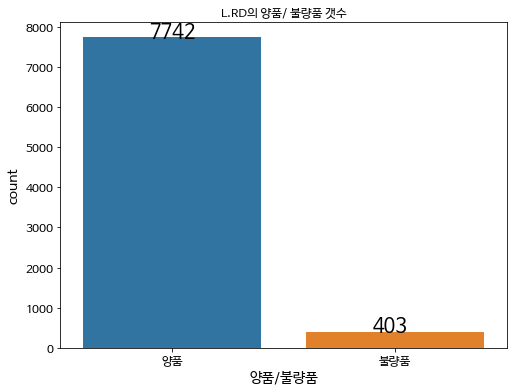

In [ ]:
show_one_labels_cnt(y_data_labels_5p)

### 2) 훈련데이터와 테스트데이터 분리

In [ ]:
# MinMaxScaler로 데이터 스케일링한 피처를 사용
X_data = X_mm_noVIF_scaled.copy()
all_data_5p_LRD = pd.concat([X_data, y_data_labels_5p.iloc[:,0]], axis=1)

X_train_5p, X_test_5p, y_train_5p, y_test_5p = train_test_split(X_data, y_data_labels_5p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_5p.shape)
print(y_test_5p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_5p.value_counts()/y_train_5p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_5p.value_counts()/y_test_5p.count())

(6516,)
(1629,)
0    0.95043
1    0.04957
Name: L.RD, dtype: float64
0    0.95089
1    0.04911
Name: L.RD, dtype: float64


In [ ]:
print(X_train_5p.shape)
print(y_train_5p.shape)

(6516, 324)
(6516,)


### 3)RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_5p = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_5p.fit(X_train_5p, y_train_5p)
rf_predict_5p = rf_clf_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_clf_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9613259668508287
정밀도: 0.717948717948718
재현율: 0.35
F1: 0.47058823529411764
AUC: 0.9172934151065203


In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='bootstrapTrueMaxSamplesNone.dot',
                max_depth = 3, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','bootstrapTrueMaxSamplesNone.dot', '-o', 'bootstrapTrueMaxSamplesNone.png', '-Gdpi=600'])

0

#### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.LEFT.BOTTOM.1FI33513.PV          0.024246
D_AB7_L_UL                             0.018495
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.010178
D_AB8_U_LR                             0.009254
N2.TO.EA1315B.1FI33528A_PV             0.008656
D_AB6_U_LR                             0.008465
D_GLS_AB7_LR                           0.008346
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.008330
rc_btm_up_dn                           0.008030
DB.BTM.DN.STM.TC.RC.1TI40407_PV        0.007897
TMP.GLASS..ZONE.AB1.E1.1TI40201.PV     0.007658
S_AB10_AB11_U_L                        0.007469
S_C1_C2_U_L                            0.007428
top_1                                  0.007339
N2.TO.EA1315A.1FI33504A_PV             0.006614
D_AB9_L_LR                             0.006469
ATM.FLOW.SECT.10.N2.1FIC33417.PV       0.006458
DB.BTM.DN.STM.TC.RE.1TI40408_PV        0.006049
ATM.FLOW.SECT.3.N2.1FI33403.PV         0.005895
ROOF.HEATING.Zone80.1JIC31180.PV       0.005811
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0

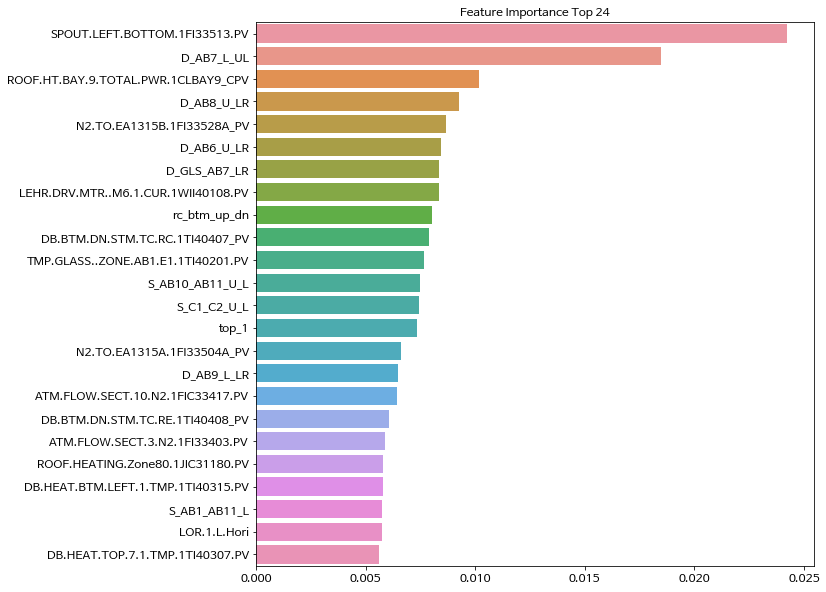

In [ ]:
ft_importance_values_5p = rf_clf_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

#### 트리구조 저장 및 출력

In [ ]:
estimator_5p  = rf_clf_5p.estimators_[99]

# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                feature_names=X_train_5p.columns,
                out_file='1_randomForest_LRD_5p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_5p_MinMax.dot', '-o', '1_randomForest_LRD_5p_MinMax.png', '-Gdpi=600'])

0

#### 피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

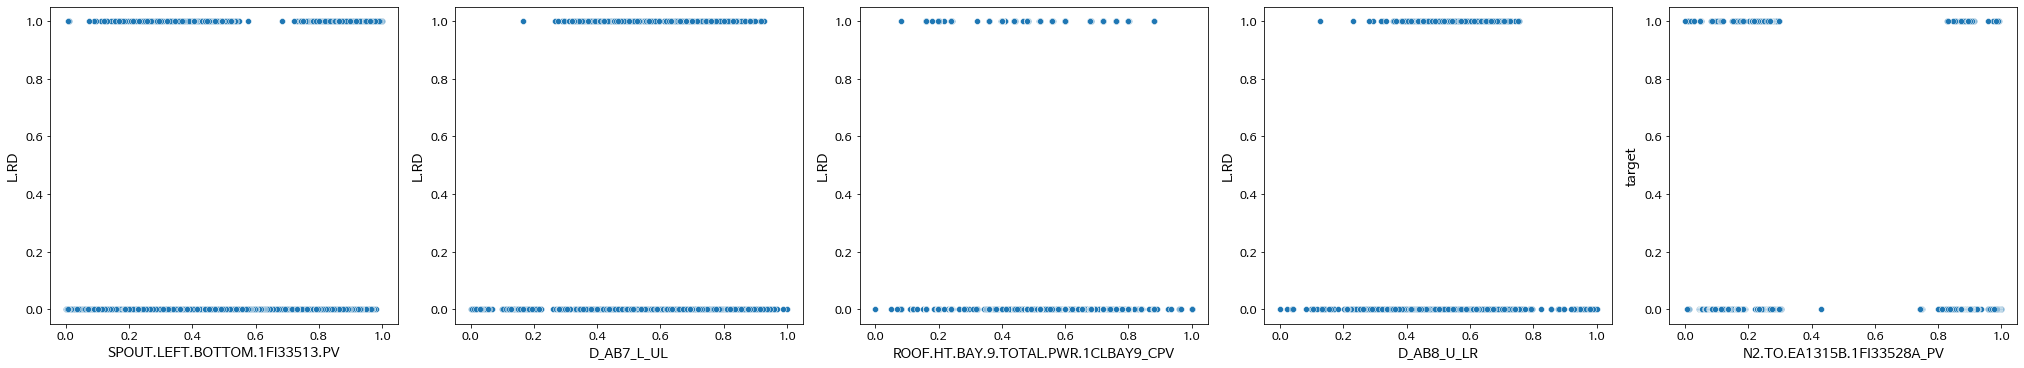

In [ ]:
show_feature_label(ft_top24, y_data_labels_5p)

### 4) 하이퍼파라미터 튜닝

In [ ]:
params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 17, 19, 20], 
          'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50, 100, 130]}

# cv를 5로 설정
# 재현율을 높이도록 하이퍼파라미터 튜닝
gridcv_5 = GridSearchCV(rf_clf_5p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
gridcv_5.fit(X_train_5p, y_train_5p)

#### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
rf_estimator_5p = gridcv_5.best_estimator_
print(rf_estimator_5p)

In [ ]:
rf_estimator_5p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_5p.fit(X_train_5p, y_train_5p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
rf_predict_5p = rf_estimator_5p.predict(X_test_5p)
rf_predict_proba_5p = rf_estimator_5p.predict_proba(X_test_5p)[:,1]
get_clf_eval(y_test_5p, rf_predict_5p, rf_predict_proba_5p)

정확도: 0.9588704726826274
정밀도: 0.7096774193548387
재현율: 0.275
F1: 0.3963963963963964
AUC: 0.9158650742414463


#### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.LEFT.BOTTOM.1FI33513.PV            0.043002
D_AB7_L_UL                               0.019943
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV      0.015480
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV      0.015476
ATM.FLOW.SECT.10.N2.1FIC33417.PV         0.013546
D_AB8_U_LR                               0.012694
D_AB8_L_UL                               0.011627
DB.BTM.DN.STM.TC.RC.1TI40407_PV          0.011187
ROOF.HT.BAY.10.TOTAL.PWR.1CLBAY10_CPV    0.010625
rc_btm_up_dn                             0.010279
N2.TO.EA1315A.1FI33504A_PV               0.010061
N2.TO.EA1315B.1FI33528A_PV               0.009777
S_C1_C2_U_L                              0.009258
S_C4_RET_L                               0.009126
S_AB10_AB11_U_L                          0.008832
S_AB10_AB11_L_L                          0.008668
TMP.GLASS..ZONE.AB1.E1.1TI40201.PV       0.008510
DB.HEAT.TOP.7.1.TMP.1TI40307.PV          0.008497
LOWER.C4..Z204.TMP.1TIC42551.PV          0.008035
X1WOS45105_PV                            0.007995


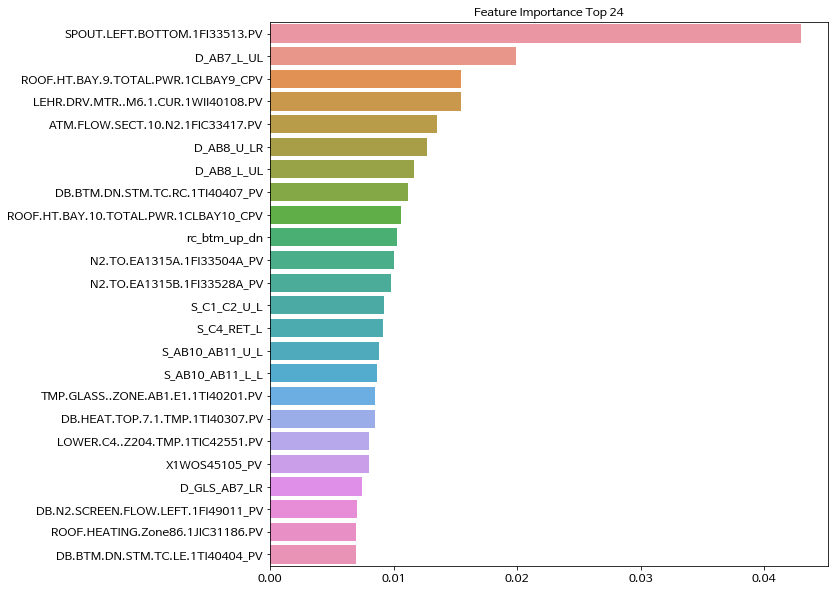

In [ ]:
ft_importance_values_5p = rf_estimator_5p.feature_importances_
ft_series_5p = pd.Series(ft_importance_values_5p, index = X_train_5p.columns)
ft_top24 = ft_series_5p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

## 3.임계치 : 상위 10%


### 1) 레이블 라벨링

In [ ]:
quartile_10p = y_data.quantile(q=0.9)

print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
y_data_labels_10p = pd.DataFrame(np.where(y_data > quartile_10p, 1, 0), columns = y_data.columns)
y_data_labels_10p.head()

<각 컬럼의 상위 10% 임계점>
 L.RD    0.04
Name: 0.9, dtype: float64


,L.RD
0,0
1,0
2,0
3,0
4,0


In [ ]:
origin_y_data = y_data.copy()
y_data_labels_10p = y_data.copy()

quartile_10p = origin_y_data.quantile(q=0.9)
print('<각 컬럼의 상위 10% 임계점>\n',quartile_10p)
for i in range(len(origin_y_data.columns)) : 
    column_name = origin_y_data.columns[i]

    # 양품 데이터 설정
    y_data_labels_10p[column_name] = 0
    condition = (origin_y_data[column_name] > quartile_10p[i])
    # 불량품 레이블 데이터 설정
    y_data_labels_10p[column_name][condition] = 1

<각 컬럼의 상위 10% 임계점>
 L.RD    0.04
Name: 0.9, dtype: float64


####  임계치가 상위 10% 설정의 경우, 카운트 그래프

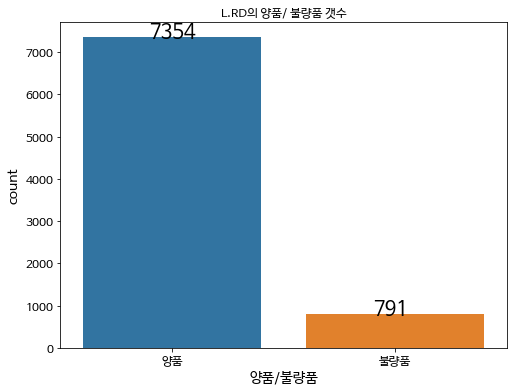

In [ ]:
show_one_labels_cnt(y_data_labels_10p)

### 2) 훈련데이터와 테스트데이터 분리

In [ ]:
X_train_10p, X_test_10p, y_train_10p, y_test_10p = train_test_split(X_data, y_data_labels_10p.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_10p.shape)
print(y_test_10p.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_10p.value_counts() / y_train_10p.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_10p.value_counts() / y_test_10p.count())

(6516,)
(1629,)
0    0.902701
1    0.097299
Name: L.RD, dtype: float64
0    0.903622
1    0.096378
Name: L.RD, dtype: float64


### 3) RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_10p = RandomForestClassifier(random_state=42)
rf_clf_10p.fit(X_train_10p, y_train_10p)
rf_predict_10p = rf_clf_10p.predict(X_test_10p)
rf_predict_proba_10p = rf_clf_10p.predict_proba(X_test_10p)[:,1]
get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

정확도: 0.9269490484960098
정밀도: 0.7209302325581395
재현율: 0.39490445859872614
F1: 0.5102880658436215
AUC: 0.858583148712268


#### 하이퍼파라미터 튜닝 전의 피처 중요도

SPOUT.LEFT.BOTTOM.1FI33513.PV          0.015502
UPPER.C1..Z155.TMP.1TIC42201.PV        0.008451
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.008110
D_AB7_L_UL                             0.008055
N2.TO.EA1315A.1FI33504A_PV             0.007866
ATM.FLOW.SECT.10.N2.1FIC33417.PV       0.007805
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.007741
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.007180
S_AB11_C1_U_L                          0.007000
X.1.LEHR.O2.ANALYZER.1AI44111.PV       0.006840
N2.TO.EA1315B.1FI33528A_PV             0.006792
TMP.GLASS..ZONE.AB1.E1.1TI40201.PV     0.006757
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.006284
D_C1_L_UL                              0.006093
le_re_btm_dn                           0.005778
LOWER.C1..Z168.TMP.1TIC42257.PV        0.005555
DB.BTM.DN.STM.TC.LE.1TI40404_PV        0.005483
DB.HEAT.TOP.7.1.TMP.1TI40307.PV        0.005469
D_GLS_AB7_LR                           0.005313
ROOF.HEATING.Zone36.1JIC31136.PV       0.005289
l_r_tin_bay5                           0

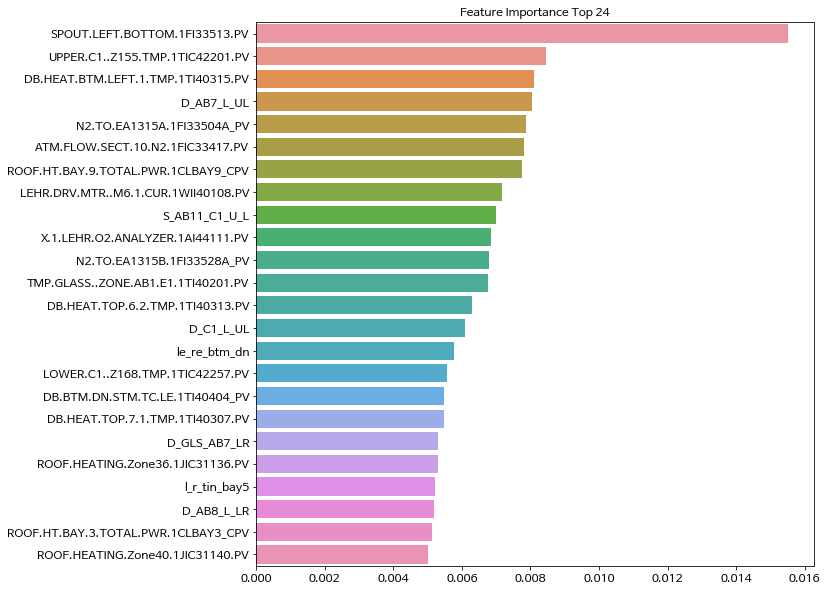

In [ ]:
ft_importance_values_10p = rf_clf_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

#### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_clf_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_10p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_10p_MinMax.dot', '-o', working_dir + '1_randomForest_LRD_10p_MinMax.png', '-Gdpi=600'])

0

####   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

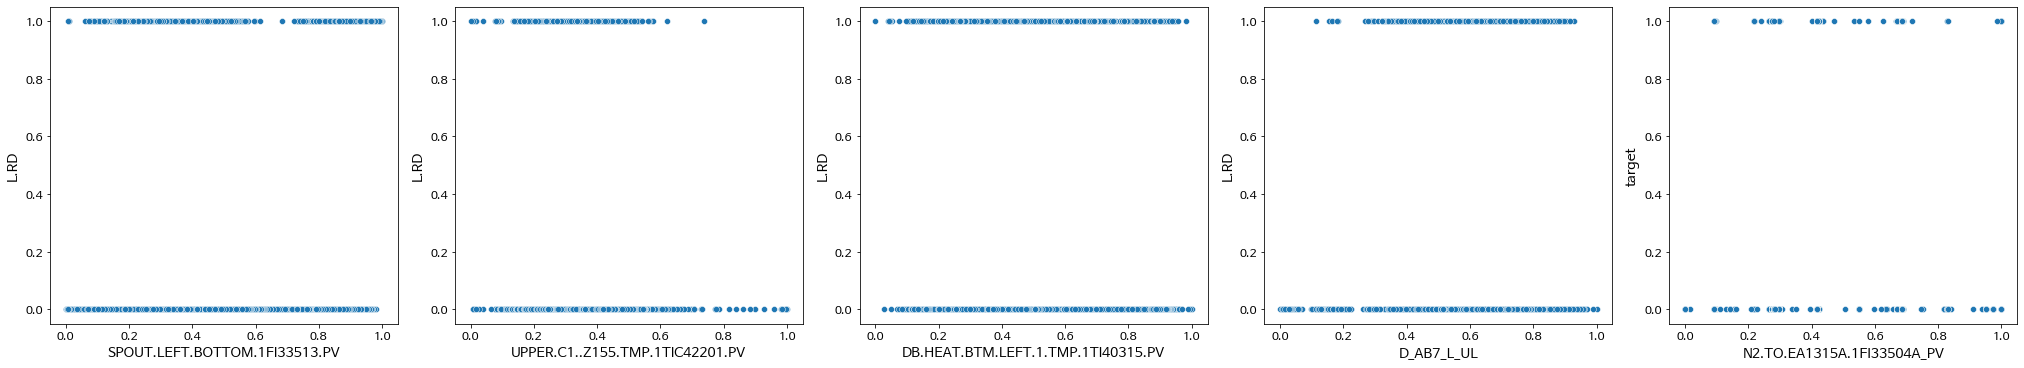

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

### 4) 하이퍼파라미터 튜닝

In [ ]:
# #파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
# #실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
          'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# cv를 5로 설정
# 재현율을 높이도록 하이퍼파라미터 튜닝
gridcv_10p = GridSearchCV(rf_clf_10p, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
gridcv_10p.fit(X_train_10p, y_train_10p)

#### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
rf_estimator_10p = gridcv_10p.best_estimator_
print(rf_estimator_10p)
rf_predict_10p = rf_estimator_10p.predict(X_test_10p)
rf_predict_proba_10p = rf_estimator_10p.predict_proba(X_test_10p)[:, 1]
get_clf_eval(y_test_10p, rf_predict_10p, rf_predict_proba_10p)

In [ ]:
rf_estimator_10p = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_10p.fit(X_train_10p, y_train_10p)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=18, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### 하이퍼파라미터 튜닝 후의 피처 중요도

SPOUT.LEFT.BOTTOM.1FI33513.PV          0.025403
ATM.FLOW.SECT.10.N2.1FIC33417.PV       0.013791
D_AB7_L_UL                             0.012328
LEHR.DRV.MTR..M6.1.CUR.1WII40108.PV    0.012284
S_C1_C2_U_L                            0.011245
S_AB11_C1_U_L                          0.010002
ROOF.HT.BAY.9.TOTAL.PWR.1CLBAY9_CPV    0.009494
N2.TO.EA1315A.1FI33504A_PV             0.009482
UPPER.C1..Z155.TMP.1TIC42201.PV        0.009263
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV     0.009212
ROOF.HT.BAY.7.TOTAL.PWR.1CLBAY7_CPV    0.008710
S_AB10_AB11_L_L                        0.008387
DB.HEAT.TOP.6.2.TMP.1TI40313.PV        0.008141
TMP.GLASS..ZONE.AB1.E1.1TI40201.PV     0.007390
ROOF.HEATING.Zone30.1JIC31130.PV       0.007308
D_AB3_L_UL                             0.007245
D_AB7_L_LR                             0.007186
DB.BTM.DN.STM.TC.RC.1TI40407_PV        0.007093
LOWER.C2..Z182.TMP.1TIC42357.PV        0.006976
l_r_tin_bay5                           0.006848
S_AB10_AB11_U_L                        0

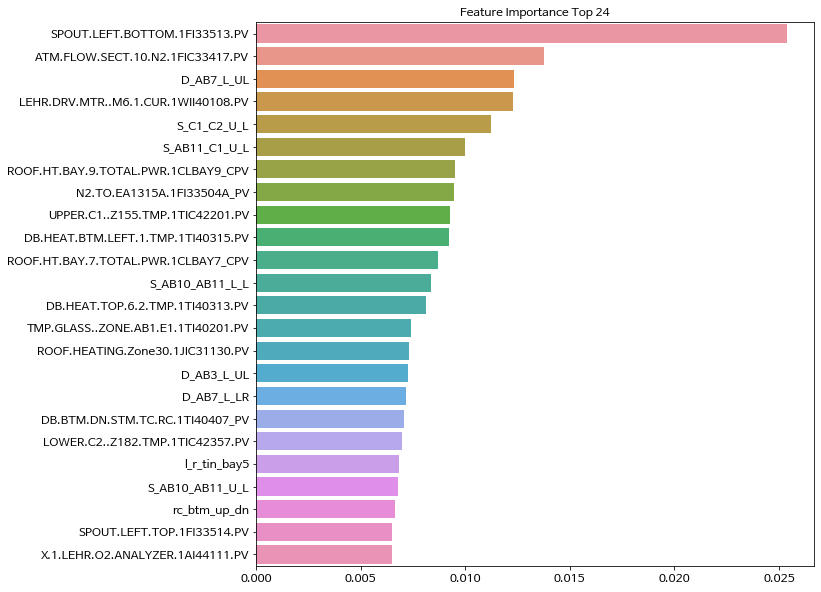

In [ ]:
ft_importance_values_10p = rf_estimator_10p.feature_importances_
ft_series_10p = pd.Series(ft_importance_values_10p, index = X_train_10p.columns)
ft_top24 = ft_series_10p.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

#### 트리구조 저장 및 출력

In [ ]:
estimator_10p  = rf_estimator_10p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_10p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_10p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_10p_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_10p_MinMax.png', '-Gdpi=600'])

0

####   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

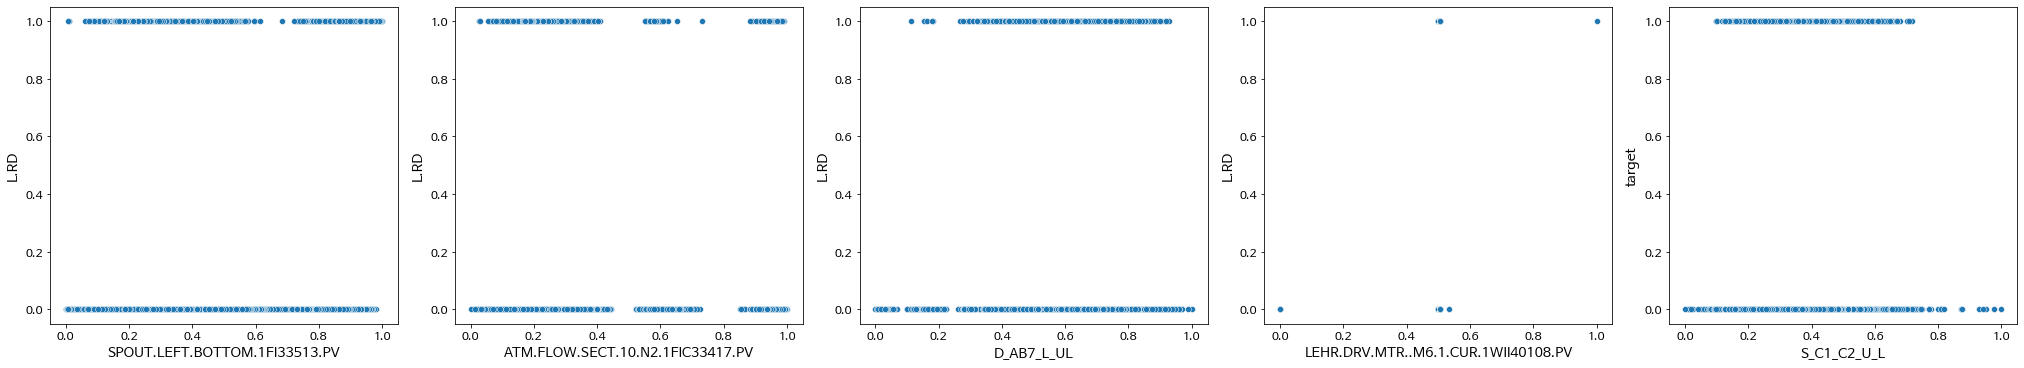

In [ ]:
show_feature_label(ft_top24, y_data_labels_10p)

## 3.임계치 : 레이블 불량률의 값이 0.01
- 레이블에 대해 불량품(1)과 양품(0)으로 분류
- 0.01이상의 데이터는 불량품, 이외는 양품으로 Labeling을 한다.


### 1) 레이블 라벨링

In [ ]:
y_data_labels_001 = pd.DataFrame(np.where(y_data > 0.01, 1, 0), columns = y_data.columns)
y_data_labels_001.head()

,L.RD
0,1
1,0
2,1
3,0
4,0


#### 임계치가 0.01 설정의 경우, 카운트 그래프

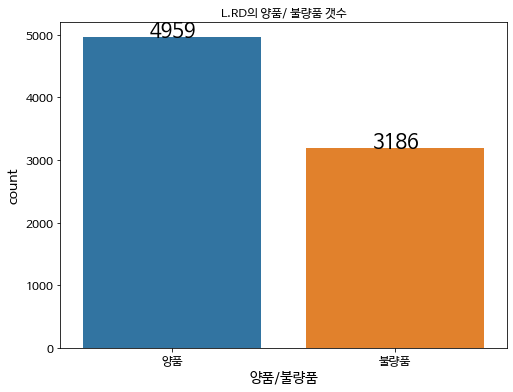

In [ ]:
show_one_labels_cnt(y_data_labels_001)

### 2) 훈련데이터와 테스트데이터 분리

In [ ]:
X_train_001, X_test_001, y_train_001, y_test_001 = train_test_split(X_data, y_data_labels_001.iloc[:,0], 
                                                   test_size=0.2, random_state=42)
#훈련 데이터 와 테스트 데이터 비율 확인
print(y_train_001.shape)
print(y_test_001.shape)


#원본 데이터 와의 비율을 확인 
#원본 데이터의 비율에 맞춰서 샘플링 하는 것을 층화 표본 추출이라고 합니다.

#훈련 데이터의 레이블 비율 확인
print(y_train_001.value_counts()/y_train_001.count())
#테스트 데이터의 레이블 비율 확인
print(y_test_001.value_counts()/y_test_001.count())

(6516,)
(1629,)
0    0.610804
1    0.389196
Name: L.RD, dtype: float64
0    0.600982
1    0.399018
Name: L.RD, dtype: float64


### 3) RandomForest모델 훈련 및 검증

In [ ]:
rf_clf_001 = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_clf_001.predict(X_test_001)
rf_predict_proba_001 = rf_clf_001.predict_proba(X_test_001)[:,1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.7016574585635359
정밀도: 0.6620553359683794
재현율: 0.5153846153846153
F1: 0.5795847750865052
AUC: 0.7402042900919306


#### 하이퍼파라미터 튜닝 전의 피처 중요도

UPPER.C1..Z155.TMP.1TIC42201.PV          0.009007
S_AB11_C1_L_L                            0.007996
ROOF.HT.BAY.7.TOTAL.PWR.1CLBAY7_CPV      0.007327
S_AB11_C1_U_L                            0.007226
D_C1_L_UL                                0.006817
ROOF.HT.BAY.11.TOTAL.PWR.1CLBAY11_CPV    0.006501
ATM.N2.H2.5..함유율.1CLFI33402_CPV          0.005946
TMP.TIN..BAY.1.LEFT.1TI30201.PV          0.005825
ROOF.HEATING.Zone49.1JIC31149.PV         0.005759
ROOF.HEATING.Zone80.1JIC31180.PV         0.005585
DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV       0.005466
ROOF.HEATING.Zone57.1JIC31157.PV         0.005415
SPOUT.LEFT.BOTTOM.1FI33513.PV            0.005348
N2.TO.HOOD.UP.STREAM.1FI33506A_PV        0.005176
LOWER.C3..Z193TMP.1TIC42454.PV           0.005097
S_C1_C2_U_L                              0.005052
UPPER.C1..Z157.TMP.1TIC42203.PV          0.004999
N2.TO.EA1315B.1FI33528A_PV               0.004964
N2.TO.EA1315A.1FI33504A_PV               0.004828
top_7                                    0.004757


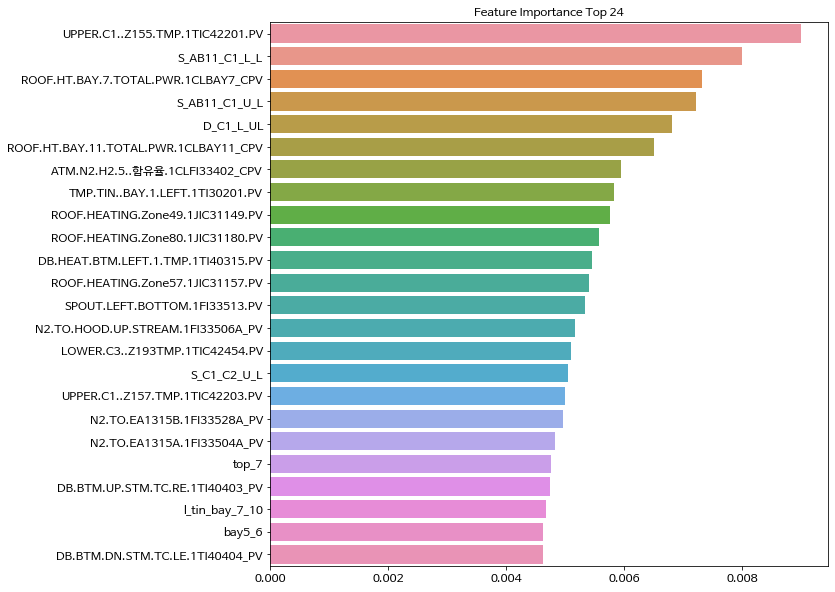

In [ ]:
ft_importance_values_001 = rf_clf_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

#### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_clf_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='1_randomForest_LRD_001_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','1_randomForest_LRD_001_MinMax.dot', '-o', working_dir + '1_randomForest_LRD_001_MinMax.png', '-Gdpi=600'])

0

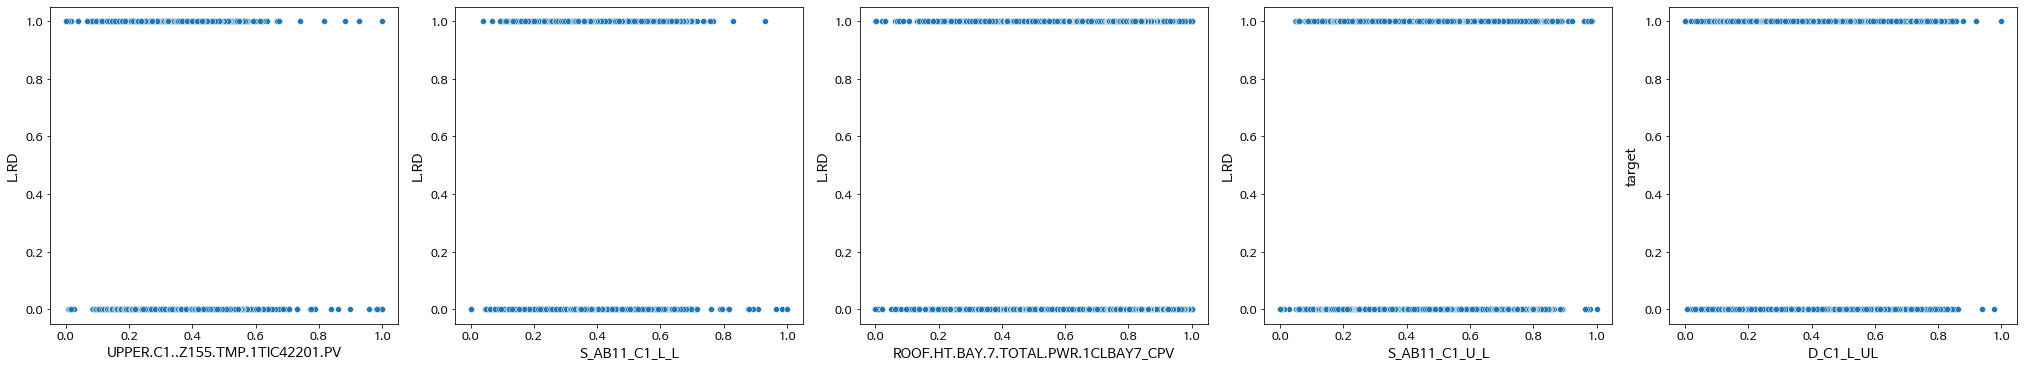

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)

### 4) 하이퍼파라미터 튜닝

In [ ]:
#파라미터 생성 - 시간 관계상 파라미터의 개수를 2개씩으로 설정한 것이고
#실제 모델을 가지고 학습할 때는 더 다양한 값을 설정해야 합니다.
params = {'n_estimators':[30, 50, 70, 100], 'max_depth':[15, 18, 20], 
          'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 20, 50,  100]}

# cv를 5로 설정
# 재현율을 높이도록 하이퍼파라미터 튜닝
gridcv_001 = GridSearchCV(rf_clf_001, param_grid = params, cv=5, n_jobs=-1, scoring='recall')
gridcv_001.fit(X_train_001, y_train_001)

#### 하이퍼파라미터 튜닝으로 향상된 모델의 성능 평가

In [ ]:
rf_estimator_001 = gridcv_001.best_estimator_
print(rf_estimator_001)
rf_predict_001 = rf_estimator_001.predict(X_test_001)
rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

In [ ]:
# rf_estimator_001 = gridcv_001.best_estimator_
rf_estimator_001 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
rf_estimator_001.fit(X_train_001, y_train_001)
rf_predict_001 = rf_estimator_001.predict(X_test_001)
rf_predict_proba_001 = rf_estimator_001.predict_proba(X_test_001)[:, 1]
get_clf_eval(y_test_001, rf_predict_001, rf_predict_proba_001)

정확도: 0.6813996316758748
정밀도: 0.6286836935166994
재현율: 0.49230769230769234
F1: 0.5522001725625539
AUC: 0.7318268248605327


#### 하이퍼파라미터 튜닝 후의 피처 중요도

ROOF.HT.BAY.7.TOTAL.PWR.1CLBAY7_CPV      0.015208
UPPER.C1..Z155.TMP.1TIC42201.PV          0.015186
S_AB11_C1_U_L                            0.014620
cluster                                  0.009903
D_C1_L_UL                                0.009869
ROOF.HT.BAY.11.TOTAL.PWR.1CLBAY11_CPV    0.009204
S_C1_C2_U_L                              0.008922
LEHR.DRV.MTR..M7.1.SPD.1WSI40110.1       0.008244
TMP.TIN..BAY.1.LEFT.1TI30201.PV          0.008101
SPOUT.LEFT.BOTTOM.1FI33513.PV            0.007734
LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101        0.007708
le_re_btm_dn                             0.007601
LOWER.C1..Z168.TMP.1TIC42257.PV          0.007530
ATM.FLOW.SECT.10.N2.1FIC33417.PV         0.007311
S_AB11_C1_L_L                            0.007257
TMP.GLASS..BAY.8.1TI30108.PV             0.006860
ATM.N2.H2.5..함유율.1CLFI33402_CPV          0.006748
UPPER.C1..Z157.TMP.1TIC42203.PV          0.006653
DB.BTM.DN.STM.TC.LE.1TI40404_PV          0.006574
ROOF.HEATING.Zone49.1JIC31149.PV         0.006135


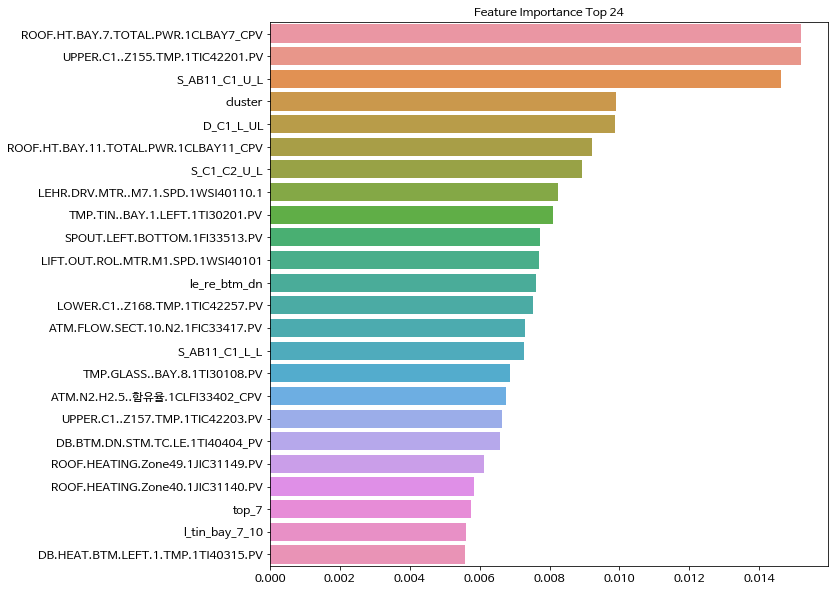

In [ ]:
ft_importance_values_001 = rf_estimator_001.feature_importances_
ft_series_001 = pd.Series(ft_importance_values_001, index = X_train_001.columns)
ft_top24 = ft_series_001.sort_values(ascending=False)[:24]
print(ft_top24)
# 시각화
plt.figure(figsize=(10,10))
plt.title('Feature Importance Top 24')
sns.barplot(x=ft_top24, y=ft_top24.index)
plt.show()

#### 트리구조 저장 및 출력

In [ ]:
estimator_001  = rf_estimator_001.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_001,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_001_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_001_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_001_MinMax.png', '-Gdpi=600'])

0

####   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

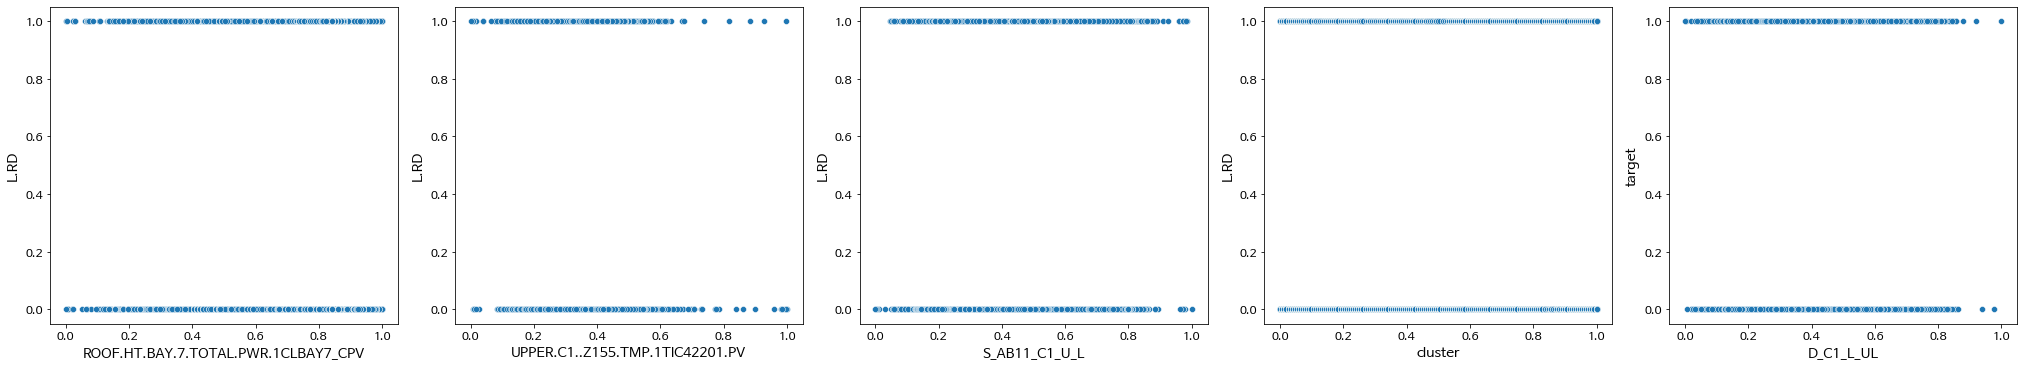

In [ ]:
show_feature_label(ft_top24, y_data_labels_001)

# RFE

- X_train_001, X_test_001, y_train_001, y_test_001

## 피처중요도가 높은 24개의 피처 추출

In [ ]:
X_train_001_24 = pd.DataFrame(data=X_train_001,columns=ft_top24.index, index=X_train_001.index)
X_test_001_24 = pd.DataFrame(data=X_test_001,columns=ft_top24.index, index=X_train_001.index)

In [ ]:
from sklearn.feature_selection import RFE
rfe_selector_001 = RFE(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False),  n_features_to_select= 5)

rfe_fit = rfe_selector_001.fit(X_train_001_24, y_train_001)

In [ ]:
rfe_selector_001.estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

#### RFE로 추출된 5개의 피처

In [ ]:
feature_names = X_train_001_24.columns
X_train_001_5 = X_train_001_24[feature_names[rfe_selector_001.support_]]
X_test_001 = X_test_001_24[feature_names[rfe_selector_001.support_]]

In [ ]:
X_train_001_5.columns

Index(['S_AB11_C1_U_L', 'ROOF.HT.BAY.11.TOTAL.PWR.1CLBAY11_CPV', 'S_C1_C2_U_L',
       'S_AB11_C1_L_L', 'DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV'],
      dtype='object')

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_clf_001_5 = DecisionTreeClassifier(random_state=42, max_leaf_nodes=20)
dt_clf_001_5.fit(X_train_001_5, y_train_001)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

### 트리구조 저장 및 출력

In [ ]:
# .dot 파일로 export 해줍니다
export_graphviz(dt_clf_001_5,
                feature_names=X_train_001_24.columns,
                out_file='RandomForest_LRD_001_RFE.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','RandomForest_LRD_001_RFE.dot', '-o', working_dir + 'RandomForest_LRD_001_RFE.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

In [ ]:
X_train_001_24

,S_AB11_C1_U_L,ROOF.HT.BAY.11.TOTAL.PWR.1CLBAY11_CPV,S_C1_C2_U_L,S_AB11_C1_L_L,DB.HEAT.BTM.LEFT.1.TMP.1TI40315.PV
dat...date.name.,,,,,
2016-09-27 06,0.791097,0.287295,0.317333,0.530076,0.946768
2016-12-14 01,0.508266,0.561985,0.278026,0.381540,0.505538
2016-11-29 16,0.493697,0.448103,0.312224,0.375601,0.796236
2016-12-16 15,0.514919,0.599898,0.299297,0.391038,0.624597
2016-09-25 02,0.812307,0.291082,0.329127,0.566852,0.938138
...,...,...,...,...,...
2016-08-26 18,0.773527,0.271647,0.184483,0.544723,0.347177
2016-09-03 11,0.771883,0.254709,0.312249,0.478939,0.344605
2016-02-11 08,0.537819,0.070123,1.000000,1.000000,0.453479


In [ ]:
show_feature_label(X_train_001_24, y_train_001)

AttributeError: ignored

In [ ]:
X_train_5p_24 = pd.DataFrame(data=X_train_5p,columns=ft_top24.index, index=X_train_5p.index)
X_test_5p_24 = pd.DataFrame(data=X_test_5p,columns=ft_top24.index, index=X_train_5p.index)

In [ ]:
estimator_5p  = rf_estimator_5p.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(estimator_5p,
                  feature_names=X_data.columns,
                out_file='2_randomForest_LRD_5p_MinMax.dot',
                # max_depth = 10, # 표현하고 싶은 최대 depth
                # precision = 3, # 소수점 표기 자릿수
                filled = True, # class별 color 채우기
                rounded=True # 박스의 모양을 둥글게
                )
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng','2_randomForest_LRD_5p_MinMax.dot', '-o', working_dir + '2_randomForest_LRD_5p_MinMax.png', '-Gdpi=600'])

0

###   피처중요도가 높은 5개의 피처와 레이블과의 관계그래프

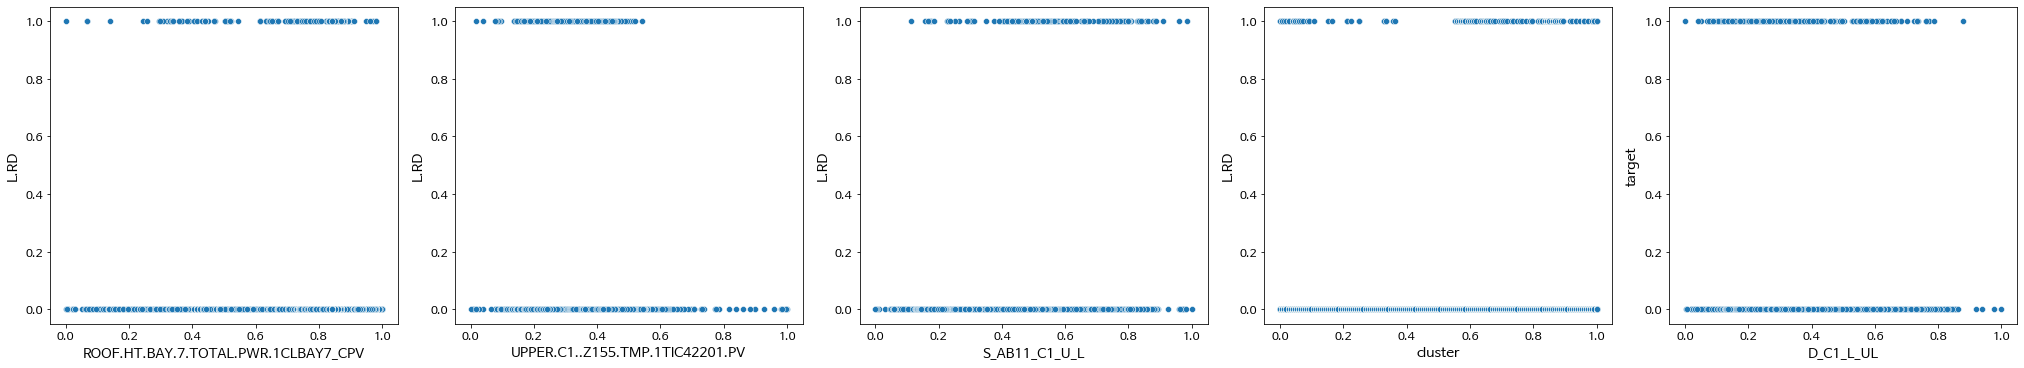

In [ ]:
show_feature_label(ft_top24, y_train_001)